In this notebook following analysis is performed:
1. Comparison of the different water treatment trains based on the brine disposal method. Select minimum, maximum and medium cost treatment trains
2. Sensitivity of the LCOW of the treatment train to the treated volume for each treatment train selected in step 1
3. Sensitivity of the LCOW of the treatment train to the distance the brine needs to be transported for disposal

In [1]:
import pandas as pd
import numpy as np
from watertap3.utils import watertap_setup, get_case_study, run_model 
from watertap3.utils import run_watertap3, run_model_no_print, run_and_return_model
import pyomo.util.infeasible as infeas
from idaes.core.util.model_statistics import *
import matplotlib.pyplot as plt
from truck_pipe_cost_functions import truck_costing, pipe_costing
from watertap3.utils.post_processing import get_results_table

Baseline test case

In [2]:
case_study = 'big_spring'
scenario = 'dwi_a'
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'

m = watertap_setup(case_study=case_study, scenario=scenario)
m = get_case_study(m=m)
m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

m.fs.reverse_osmosis.membrane_area.unfix()
m.fs.reverse_osmosis.feed.pressure.unfix()

m.fs.big_spring_feed.flow_vol_in.fix(72037 * 6.30902e-5) #gpm to m3s
m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(0.698) #kg/m3
m.fs.well_field.lift_height.fix(174)

m.fs.costing_param.electricity_price = 0.0652
m = run_and_return_model(m, objective=True)
m, df = get_results_table(m=m, case_study='test', scenario=scenario)    
m.fs.costing.LCOW.value()


Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
...............................

0.523189563485043

In [3]:
m.fs.costing.capital_recovery_factor()

0.06505143508027657

Comparison of all the brine management methods

Sensitivity of LCOW to volume of water being treated- baseline case

In [29]:
case_study = 'big_spring'
scenario = 'dwi_a'
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'

m = watertap_setup(case_study=case_study, scenario=scenario)
m = get_case_study(m=m)
m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

m.fs.reverse_osmosis.membrane_area.unfix()
m.fs.reverse_osmosis.feed.pressure.unfix()
LCOWList_dwi_a = np.array([])
flow_list = [0.075,0.5,1.5,2.25,4.5]
for flow in flow_list:
    print(flow)
    m.fs.big_spring_feed.flow_vol_in.fix(flow)
    m = run_and_return_model(m, objective=True)
    print(m.fs.costing.LCOW.value())
    LCOWList_dwi_a= np.concatenate((LCOWList_dwi_a,[m.fs.costing.LCOW.value()]))
m, df = get_results_table(m=m, case_study='high_flow', scenario=scenario)      
LCOWList_dwi_a
dwi_a_conc_flow = m.fs.deep_well_injection.flow_vol_in[0].value
dwi_a_total_water_recovery = m.fs.costing.system_recovery()
dwi_a_update_basis = (1-dwi_a_total_water_recovery)/dwi_a_total_water_recovery


Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
...............................

In [28]:
4.5*dwi_a_total_water_recovery

3.9815493200728294

In [23]:
LCOWList_dwi_a

array([0.79646503, 0.61807016, 0.57024175, 0.55744269, 0.53959423])

Sensitivity of LCOW to volume of water being treated-medium cost case

In [30]:
case_study = 'big_spring'
scenario = 'zld_a'
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'


m = watertap_setup(case_study=case_study, scenario=scenario)
m = get_case_study(m=m)
m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

m.fs.ro_first_stage.membrane_area.unfix()
m.fs.ro_first_stage.feed.pressure.unfix()
m.fs.ro_second_stage.membrane_area.unfix()
m.fs.ro_second_stage.feed.pressure.unfix()

LCOWList_zld_a = np.array([])
flow_list = [0.075,0.5,1.5,2.25,4.5]
for flow in flow_list:
    print(flow)
    m.fs.big_spring_feed.flow_vol_in.fix(flow)
    # m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(0.698)
    m = run_and_return_model(m, objective=True)
    LCOWList_zld_a= np.concatenate((LCOWList_zld_a,[m.fs.costing.LCOW.value()]))
m, df = get_results_table(m=m, case_study='high_flow', scenario=scenario)     
LCOWList_zld_a
zld_a_conc_flow = m.fs.landfill_zld.flow_vol_in[0].value
zld_a_total_water_recovery = m.fs.costing.system_recovery()
zld_a_update_basis = (1-zld_a_total_water_recovery)/zld_a_total_water_recovery


Case Study = BIG SPRING
Scenario = ZLD A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
RO FIRST STAGE
PASSTHROUGH
OZONE
BIO ACTIVE FILTRATION
LIME SOFTENING
RO SECOND STAGE
UV AOP
TREATED STORAGE
EVAPORATION POND
MUNICIPAL DRINKING
LANDFILL ZLD


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 4

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 4

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = ZLD A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
RO FIRST STAGE
PASSTHROUGH
OZONE
BIO ACTIVE FILTRATION
LIME SOFTENING
RO SECOND STAGE
UV AOP
TREATED STORAGE
EVAPORATION POND
MUNICIPAL DRINKING
LANDFILL ZLD

......................

Sensitivity of LCOW to volume of water being treated- highest cost case

In [31]:
case_study = 'big_spring'
scenario = 'zld_c'
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'

m = watertap_setup(case_study=case_study, scenario=scenario)
m = get_case_study(m=m)
m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

m.fs.ro_first_stage.membrane_area.unfix()
m.fs.ro_first_stage.feed.pressure.unfix()
m.fs.ro_second_stage.membrane_area.unfix()
m.fs.ro_second_stage.feed.pressure.unfix()

LCOWList_zld_c = np.array([])
flow_list = [0.075,0.5,1.5,2.25,4.5]
for flow in flow_list:
    print(flow)
    m.fs.big_spring_feed.flow_vol_in.fix(flow)
    m = run_and_return_model(m, objective=True)
    LCOWList_zld_c= np.concatenate((LCOWList_zld_c,[m.fs.costing.LCOW.value()]))
m, df = get_results_table(m=m, case_study='high_flow', scenario=scenario)     
LCOWList_zld_c
zld_c_conc_flow = m.fs.landfill_zld.flow_vol_in[0].value
zld_c_total_water_recovery = m.fs.costing.system_recovery()
zld_c_update_basis = (1-zld_c_total_water_recovery)/zld_c_total_water_recovery


Case Study = BIG SPRING
Scenario = ZLD C


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
RO FIRST STAGE
PASSTHROUGH
OZONE
BIO ACTIVE FILTRATION
LIME SOFTENING
RO SECOND STAGE
UV AOP
TREATED STORAGE
BRINE CONCENTRATOR
CRYSTALLIZER
MUNICIPAL DRINKING
LANDFILL ZLD


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 4

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 4

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = ZLD C


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
RO FIRST STAGE
PASSTHROUGH
OZONE
BIO ACTIVE FILTRATION
LIME SOFTENING
RO SECOND STAGE
UV AOP
TREATED STORAGE
BRINE CONCENTRATOR
CRYSTALLIZER
MUNICIPAL DRINKING
LANDFI

Plot LCOW sensitivity to flow for each treatment train train

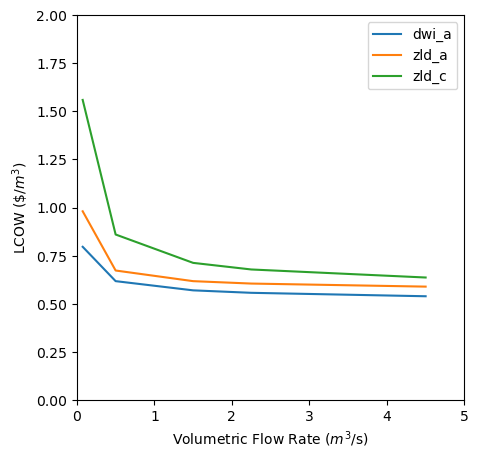

In [6]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(flow_list,LCOWList_dwi_a, label = 'dwi_a')
ax.plot(flow_list,LCOWList_zld_a, label = 'zld_a')
ax.plot(flow_list,LCOWList_zld_c, label = 'zld_c')

ax.set_ylabel('LCOW (\$/${m^3}$)')
ax.set_xlabel('Volumetric Flow Rate (${m^3}$/s)')

ax.set_ylim([0,2])
ax.set_xlim([0,5])

ax.legend()

Transport cost as a function of mode, distance and volume

(0.0, 50.0)

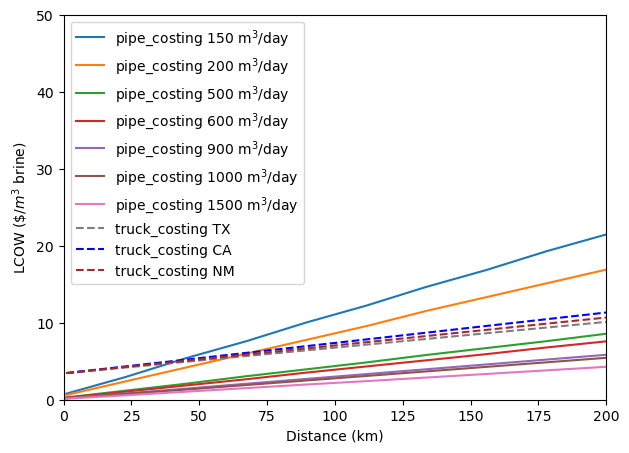

In [43]:
distance_input = np.linspace(1,200,10)
volume_input = [150,200,500,600,900,1000,1500]
output_pipe = []
output_truck_TX =[]
output_truck_CA =[]
output_truck_NM =[]

for d in distance_input:
    cost_truck_TX = truck_costing(d,wacc=0.1)
    cost_truck_CA = truck_costing(d,state='CA',wacc=0.1)
    cost_truck_NM = truck_costing(d,state='NM',wacc=0.1)
    output_truck_TX.append(cost_truck_TX)
    output_truck_CA.append(cost_truck_CA)
    output_truck_NM.append(cost_truck_NM)

for vol in volume_input:
    output_pipe_row = []
    for d in distance_input:
        cost_pipe = pipe_costing(vol,d)
        output_pipe_row.append(cost_pipe)
    output_pipe.append(output_pipe_row)

fig, ax = plt.subplots(figsize = (7,5))

for i in range(0,len(volume_input)):
    ax.plot(distance_input,output_pipe[i],label='pipe_costing '+ str(volume_input[i]) + r' ${\rm m^3}$/day')
ax.plot(distance_input,output_truck_TX,label = 'truck_costing TX',linestyle= '--')
ax.plot(distance_input,output_truck_CA,label = 'truck_costing CA',linestyle= '--',color='blue')
ax.plot(distance_input,output_truck_NM,label = 'truck_costing NM',linestyle= '--',color='brown')
ax.legend()
ax.set_xlabel("Distance (km)")
ax.set_ylabel('LCOW (\$/${m^3}$ brine)')
ax.set_xlim([0,200])
ax.set_ylim([0,50])


In [10]:
wacc = 0.1
plant_lifetime_yrs = 30

capital_recovery_factor = (wacc * (1 + wacc) ** plant_lifetime_yrs) / (((1 + wacc) ** plant_lifetime_yrs) - 1)
capital_recovery_factor

0.1060792482526339

Sensitivity check on deep well injection case with transport distance being varied:
1. This is the baseline cost case for the AMO project- verify this?
2. Default pipe transport cost is used

In [8]:
# Volume of concentrate in m3/s for input treatment volume 4.5 m3/s
print(dwi_a_conc_flow)
print(zld_a_conc_flow)
print(zld_c_conc_flow)

0.5281886769657855
0.030305428396392185
0.007203555891006922


In [32]:
# Calculate truck transport cost for alls cases
transport_costs = pd.DataFrame(columns=['process','capacity','distance','truck_cost ($/m3 brine)','pipe_cost ($/m3 brine)',
                                        'truck_tLCOW ($/m3 brine)','pipe_tLCOW ($/m3 brine)'])
# print(transport_costs)
distances = [0,10,20,50,100] # in km
capacity = {'dwi_a':dwi_a_conc_flow*3600*24,'zld_a':zld_a_conc_flow*3600*24,'zld_c':zld_c_conc_flow*3600*24}  # m3/day
LCOW = {'dwi_a':LCOWList_dwi_a[-1],'zld_a':LCOWList_zld_a[-1],'zld_c':LCOWList_zld_c[-1]}
total_water_recovery = {'dwi_a':dwi_a_total_water_recovery,'zld_a':zld_a_total_water_recovery,'zld_c':zld_c_total_water_recovery}

for case in ['dwi_a','zld_a','zld_c']:
    for d in distances:
        temp = {'process':case,'capacity': capacity[case],'distance':d,'truck_cost ($/m3 brine)': truck_costing(d),
        'pipe_cost ($/m3 brine)':pipe_costing(capacity[case],d) ,'truck_tLCOW ($/m3 brine)': LCOW[case]+truck_costing(d),
                'pipe_tLCOW ($/m3 brine)':LCOW[case]+pipe_costing(capacity[case],d)}
        # # print(temp)
        transport_costs=transport_costs.append(temp,ignore_index=True)

print(transport_costs)

   process      capacity distance truck_cost ($/m3 brine)  \
0    dwi_a  45635.501690        0                       0   
1    dwi_a  45635.501690       10                2.433973   
2    dwi_a  45635.501690       20                2.768151   
3    dwi_a  45635.501690       50                3.770683   
4    dwi_a  45635.501690      100                5.441569   
5    zld_a   2618.389013        0                       0   
6    zld_a   2618.389013       10                2.433973   
7    zld_a   2618.389013       20                2.768151   
8    zld_a   2618.389013       50                3.770683   
9    zld_a   2618.389013      100                5.441569   
10   zld_c    622.387229        0                       0   
11   zld_c    622.387229       10                2.433973   
12   zld_c    622.387229       20                2.768151   
13   zld_c    622.387229       50                3.770683   
14   zld_c    622.387229      100                5.441569   

   pipe_cost ($/m3 brin

Treatment sensitivity to transport plots

In [33]:
# Deep well injection
# Getting each unit process for treatment train
df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/high_flow_dwi_a.csv')
units = df['Unit Process Name'].unique() 
units = np.append(units,'Distance')

data_dwi_a = pd.DataFrame( columns = units[1::])

for d in distances:
    new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
    new_row= np.append(new_row,d)
    new_row = new_row.reshape((1,8))

    temp = pd.DataFrame(new_row , columns = units[1::],index = ['dwi_a'] )
    data_dwi_a= pd.concat([data_dwi_a,temp])

data_dwi_a.reset_index(inplace=True)
data_dwi_a = data_dwi_a.rename(columns={'index':'scenario'})
print(data_dwi_a)


  scenario  Well Field  Microfiltration  Reverse Osmosis    UV/AOP  \
0    dwi_a    0.030136          0.19398         0.214862  0.032233   
1    dwi_a    0.030136          0.19398         0.214862  0.032233   
2    dwi_a    0.030136          0.19398         0.214862  0.032233   
3    dwi_a    0.030136          0.19398         0.214862  0.032233   
4    dwi_a    0.030136          0.19398         0.214862  0.032233   

   Treated Storage  Municipal Drinking  Deep Well Injection  Distance  
0         0.012853            0.021213             0.034318       0.0  
1         0.012853            0.021213             0.034318      10.0  
2         0.012853            0.021213             0.034318      20.0  
3         0.012853            0.021213             0.034318      50.0  
4         0.012853            0.021213             0.034318     100.0  


In [36]:
print(dwi_a_update_basis)
print(zld_a_update_basis)
print(zld_c_update_basis)

0.1302133009663905
0.0703305678273354
0.052675362322198806


In [34]:
temp=[]
for d in distances:
    temp_tranport = (transport_costs.loc[transport_costs['process']=='dwi_a'].loc[transport_costs['distance']== d]['pipe_cost ($/m3 brine)'].values[0])*dwi_a_update_basis
    temp.append(temp_tranport)
    

data_dwi_a['Transport']=temp
data_dwi_a

,scenario,Well Field,Microfiltration,Reverse Osmosis,UV/AOP,Treated Storage,Municipal Drinking,Deep Well Injection,Distance,Transport
0,dwi_a,0.030136,0.19398,0.214862,0.032233,0.012853,0.021213,0.034318,0.0,0.000000
1,dwi_a,0.030136,0.19398,0.214862,0.032233,0.012853,0.021213,0.034318,10.0,0.009973
2,dwi_a,0.030136,0.19398,0.214862,0.032233,0.012853,0.021213,0.034318,20.0,0.014234
3,dwi_a,0.030136,0.19398,0.214862,0.032233,0.012853,0.021213,0.034318,50.0,0.027017
4,dwi_a,0.030136,0.19398,0.214862,0.032233,0.012853,0.021213,0.034318,100.0,0.048322


Text(0.5, 1.0, 'Deep Well Injection')

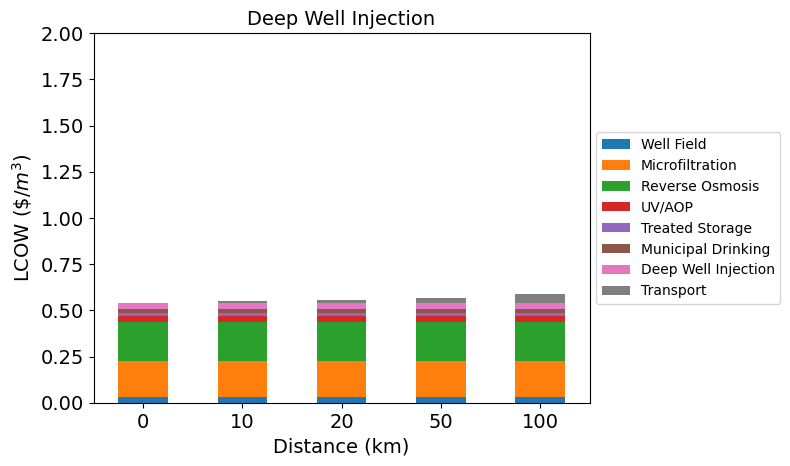

In [35]:
ax = data_dwi_a[[ 'Well Field', 'Microfiltration', 'Reverse Osmosis', 'UV/AOP',
 'Treated Storage', 'Municipal Drinking' ,'Deep Well Injection' ,'Transport','Distance']].plot.bar(x='Distance',stacked = True)
ax.set_ylim([0,2])
ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Distance (km)',fontsize =14)
ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize =14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Deep Well Injection',fontsize =14)


In [37]:
# ZLD a
# Getting each unit process for treatment train
df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/high_flow_zld_a.csv')
# df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_zld_a.csv')
units = df['Unit Process Name'].unique() 
units = np.append(units,'Distance')

data_zld_a = pd.DataFrame( columns = units[1::])

for d in distances:
    new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
    new_row= np.append(new_row,d)
    new_row = new_row.reshape((1,14))

    temp = pd.DataFrame(new_row , columns = units[1::],index = ['zld_a'] )
    data_zld_a= pd.concat([data_zld_a,temp])

data_zld_a.reset_index(inplace=True)
data_zld_a = data_zld_a.rename(columns={'index':'scenario'})
print(data_zld_a)


  scenario  Well Field  Microfiltration  RO First Stage  Passthrough    Ozone  \
0    zld_a    0.028539         0.183702        0.210975          0.0  0.00307   
1    zld_a    0.028539         0.183702        0.210975          0.0  0.00307   
2    zld_a    0.028539         0.183702        0.210975          0.0  0.00307   
3    zld_a    0.028539         0.183702        0.210975          0.0  0.00307   
4    zld_a    0.028539         0.183702        0.210975          0.0  0.00307   

   Bio Active Filtration  Lime Softening  RO Second Stage    UV/AOP  \
0               0.001442        0.034259         0.022576  0.031848   
1               0.001442        0.034259         0.022576  0.031848   
2               0.001442        0.034259         0.022576  0.031848   
3               0.001442        0.034259         0.022576  0.031848   
4               0.001442        0.034259         0.022576  0.031848   

   Treated Storage  Evaporation Pond  Municipal Drinking  Landfill ZLD  \
0          0

In [38]:
temp=[]
for d in distances:
    temp_tranport =(transport_costs.loc[transport_costs['process']=='zld_a'].loc[transport_costs['distance']== d]['truck_cost ($/m3 brine)'].values[0])*(zld_a_update_basis)
    temp.append(temp_tranport)

data_zld_a['Transport']=temp
data_zld_a

,scenario,Well Field,Microfiltration,RO First Stage,Passthrough,Ozone,Bio Active Filtration,Lime Softening,RO Second Stage,UV/AOP,Treated Storage,Evaporation Pond,Municipal Drinking,Landfill ZLD,Distance,Transport
0,zld_a,0.028539,0.183702,0.210975,0.0,0.00307,0.001442,0.034259,0.022576,0.031848,0.01266,0.038955,0.02118,0.000411,0.0,0.000000
1,zld_a,0.028539,0.183702,0.210975,0.0,0.00307,0.001442,0.034259,0.022576,0.031848,0.01266,0.038955,0.02118,0.000411,10.0,0.171183
2,zld_a,0.028539,0.183702,0.210975,0.0,0.00307,0.001442,0.034259,0.022576,0.031848,0.01266,0.038955,0.02118,0.000411,20.0,0.194686
3,zld_a,0.028539,0.183702,0.210975,0.0,0.00307,0.001442,0.034259,0.022576,0.031848,0.01266,0.038955,0.02118,0.000411,50.0,0.265194
4,zld_a,0.028539,0.183702,0.210975,0.0,0.00307,0.001442,0.034259,0.022576,0.031848,0.01266,0.038955,0.02118,0.000411,100.0,0.382709


Text(0.5, 1.0, 'Evaporation Pond + Landfill')

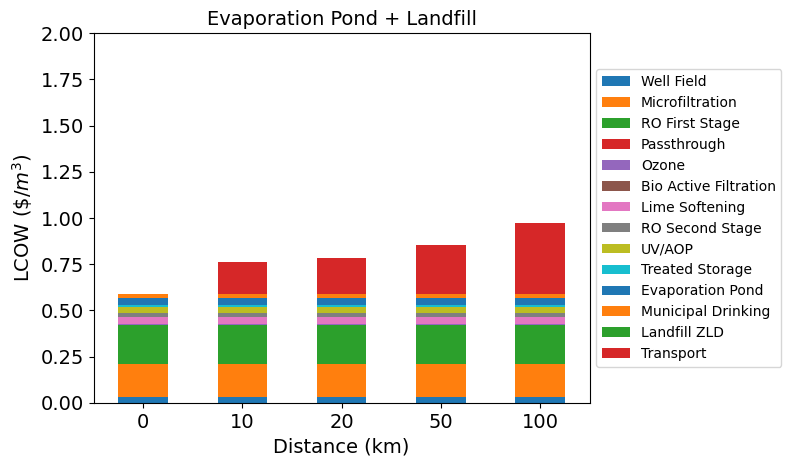

In [39]:
ax = data_zld_a[[ 'Well Field', 'Microfiltration', 'RO First Stage',
       'Passthrough', 'Ozone', 'Bio Active Filtration', 'Lime Softening',
       'RO Second Stage', 'UV/AOP', 'Treated Storage', 'Evaporation Pond',
       'Municipal Drinking', 'Landfill ZLD', 'Transport','Distance']].plot.bar(x='Distance',stacked = True)
ax.set_ylim([0,2])
ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Distance (km)',fontsize =14)
ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize =14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Evaporation Pond + Landfill',fontsize=14)

In [45]:
LCOWList_zld_a[-1]+0.382709

0.9723266307741161

In [40]:
# ZLD c
# Getting each unit process for treatment train
df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/high_flow_zld_c.csv')
units = df['Unit Process Name'].unique() 
units = np.append(units,'Distance')

data_zld_c = pd.DataFrame( columns = units[1::])

for d in distances:
    new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
    new_row= np.append(new_row,d)
    new_row = new_row.reshape((1,15))

    temp = pd.DataFrame(new_row , columns = units[1::],index = ['zld_c'] )
    data_zld_c= pd.concat([data_zld_c,temp])

data_zld_c.reset_index(inplace=True)
data_zld_c = data_zld_c.rename(columns={'index':'scenario'})
print(data_zld_c)


  scenario  Well Field  Microfiltration  RO First Stage  Passthrough  \
0    zld_c    0.028068         0.180672        0.208053          0.0   
1    zld_c    0.028068         0.180672        0.208053          0.0   
2    zld_c    0.028068         0.180672        0.208053          0.0   
3    zld_c    0.028068         0.180672        0.208053          0.0   
4    zld_c    0.028068         0.180672        0.208053          0.0   

      Ozone  Bio Active Filtration  Lime Softening  RO Second Stage    UV/AOP  \
0  0.003019                0.00141        0.033372         0.022643  0.031336   
1  0.003019                0.00141        0.033372         0.022643  0.031336   
2  0.003019                0.00141        0.033372         0.022643  0.031336   
3  0.003019                0.00141        0.033372         0.022643  0.031336   
4  0.003019                0.00141        0.033372         0.022643  0.031336   

   Treated Storage  Brine Concentrator  Crystallizer  Municipal Drinking  \
0   

In [41]:
temp=[]
for d in distances:
    temp_tranport = (transport_costs.loc[transport_costs['process']=='zld_c'].loc[transport_costs['distance']== d]['truck_cost ($/m3 brine)'].values[0])*((zld_c_update_basis))
    temp.append(temp_tranport)

data_zld_c['Transport']=temp

data_zld_c

,scenario,Well Field,Microfiltration,RO First Stage,Passthrough,Ozone,Bio Active Filtration,Lime Softening,RO Second Stage,UV/AOP,Treated Storage,Brine Concentrator,Crystallizer,Municipal Drinking,Landfill ZLD,Distance,Transport
0,zld_c,0.028068,0.180672,0.208053,0.0,0.003019,0.00141,0.033372,0.022643,0.031336,0.012601,0.075242,0.019245,0.02117,0.000132,0.0,0.000000
1,zld_c,0.028068,0.180672,0.208053,0.0,0.003019,0.00141,0.033372,0.022643,0.031336,0.012601,0.075242,0.019245,0.02117,0.000132,10.0,0.128210
2,zld_c,0.028068,0.180672,0.208053,0.0,0.003019,0.00141,0.033372,0.022643,0.031336,0.012601,0.075242,0.019245,0.02117,0.000132,20.0,0.145813
3,zld_c,0.028068,0.180672,0.208053,0.0,0.003019,0.00141,0.033372,0.022643,0.031336,0.012601,0.075242,0.019245,0.02117,0.000132,50.0,0.198622
4,zld_c,0.028068,0.180672,0.208053,0.0,0.003019,0.00141,0.033372,0.022643,0.031336,0.012601,0.075242,0.019245,0.02117,0.000132,100.0,0.286637


In [46]:
LCOWList_zld_c[-1]+0.286637

0.9235988255022094

In [34]:
units

array(['System', 'Well Field', 'Microfiltration', 'RO First Stage',
       'Passthrough', 'Ozone', 'Bio Active Filtration', 'Lime Softening',
       'RO Second Stage', 'UV/AOP', 'Treated Storage',
       'Brine Concentrator', 'Crystallizer', 'Municipal Drinking',
       'Landfill ZLD', 'Distance'], dtype=object)

Text(0.5, 1.0, 'Brine Concentrator + Crystallizer + Landfill')

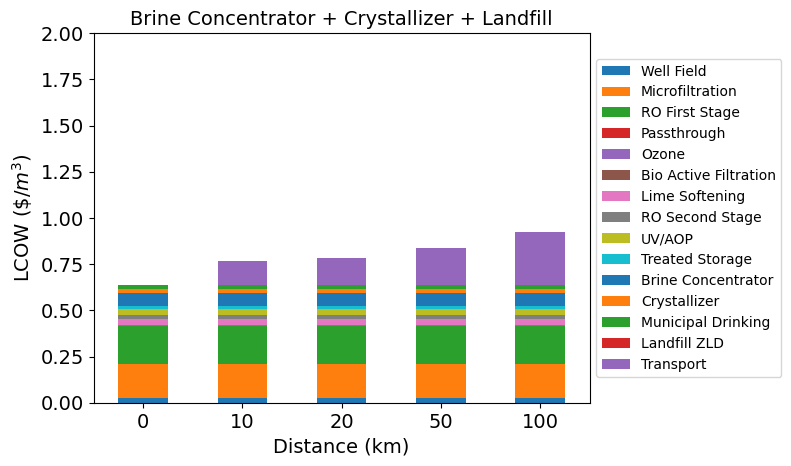

In [42]:
ax = data_zld_c[[ 'Well Field', 'Microfiltration', 'RO First Stage',
       'Passthrough', 'Ozone', 'Bio Active Filtration', 'Lime Softening',
       'RO Second Stage', 'UV/AOP', 'Treated Storage', 'Brine Concentrator', 'Crystallizer', 'Municipal Drinking',
       'Landfill ZLD', 'Transport','Distance']].plot.bar(x='Distance',stacked = True)
ax.set_ylim([0,2])
ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Distance (km)',fontsize =14)
ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize =14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Brine Concentrator + Crystallizer + Landfill',fontsize =14)

Old method here onwards. Ignore!

In [23]:
# from watertap3.utils.watertap_sensitivity import watertap_setup, get_case_study, run_model , run_watertap3,run_and_return_model
import pandas as pd
import numpy as np
import pyomo.util.infeasible as infeas
from idaes.core.util.model_statistics import *
import matplotlib.pyplot as plt

In [24]:
case_study = 'big_spring'
scenarios = ['dwi_a_0','dwi_a_10', 'dwi_a_20','dwi_a_50','dwi_a_100']
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'

LCOWList = np.array([])

for scenario in scenarios:
    m = watertap_setup(case_study=case_study, scenario=scenario, treatment_file_path = 'data/treatment_train_big_spring_dwi_a_sensitivity.csv')
    m = get_case_study(m=m)
    m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds, treatment_file_path = 'data/treatment_train_big_spring_dwi_a_sensitivity.csv')
    m.fs.reverse_osmosis.membrane_area.unfix()
    m.fs.reverse_osmosis.feed.pressure.unfix()
    m = run_and_return_model(m, objective=True)
    LCOWList= np.concatenate((LCOWList,[scenario,m.fs.costing.LCOW.value()]))

LCOWList

TypeError: watertap_setup() got an unexpected keyword argument 'treatment_file_path'

Plotting the contribution of unit process LCOW to system LCOW as a function of distance from brine disposal site

    scenario  Well Field  Microfiltration  Reverse Osmosis    UV/AOP  \
0    dwi_a_0    0.038816         0.190992         0.227291  0.178003   
1   dwi_a_10    0.038756         0.190698         0.228984  0.177835   
2   dwi_a_20    0.038704         0.190440         0.230618  0.177686   
3   dwi_a_50    0.038577         0.189814         0.235670  0.177326   
4  dwi_a_100    0.038428         0.189085         0.242839  0.176907   

   Treated Storage  Municipal Drinking  Deep Well Injection  
0         0.040120            0.024464             0.099168  
1         0.040103            0.024462             0.113910  
2         0.040088            0.024461             0.128470  
3         0.040051            0.024457             0.171291  
4         0.040008            0.024453             0.240653  


Text(0.5, 1.0, 'Deep Well Injection')

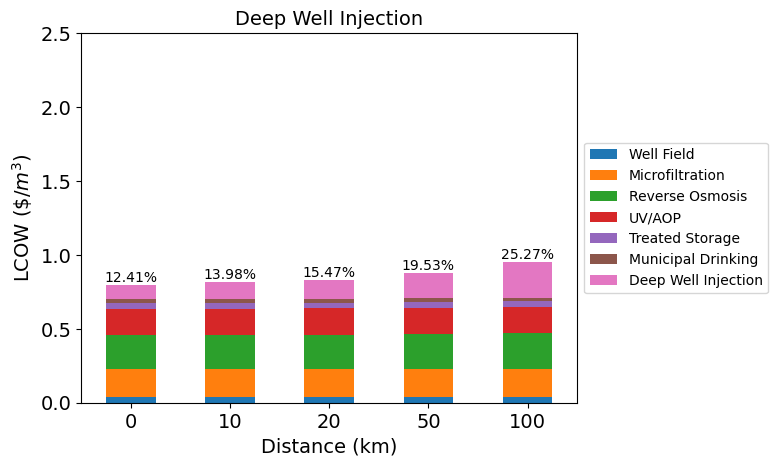

In [ ]:
scenarios = ['dwi_a_0','dwi_a_10', 'dwi_a_20','dwi_a_50','dwi_a_100']

df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_dwi_a_10.csv')
units = df['Unit Process Name'].unique() 

data = pd.DataFrame( columns = units[1::])

for scenario in scenarios:
    df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_' + scenario + '.csv')
    new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
    temp = pd.DataFrame(new_row , columns = units[1::],index= [scenario] )

    data = pd.concat([data,temp])

data.reset_index(inplace=True)
data = data.rename(columns={'index':'scenario'})
print(data)
ax = data.plot.bar(x='scenario',stacked = True)
ax.set_ylim([0,2.5])
ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Distance (km)',fontsize =14)
ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize =14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# data.sum()
perc_tranport = data['Deep Well Injection']/data.sum(axis=1)*100
perc_tranport = ["{:.2f}".format(x)+"%" for x in perc_tranport ]
ax.bar_label(ax.containers[-1],labels=perc_tranport,label_type ='edge',fontsize =10)
ax.set_title('Deep Well Injection',fontsize =14)

Sensitivity of the baseline condition to flow. This is to verify treating the entire volume of well yield makes sense.

In [ ]:
# Using the maximum and minimum well yield

max_well_yield = 4.5448 #m3/s
min_well_yield = 0.010094 * 6.30902e-5 #m3/s
max_LCOW_list = []
min_LCOW_list = []

scenarios = ['25%','50%','100%','150%','200%']
i=0
for well_yield in [0.25*max_well_yield,0.5*max_well_yield,max_well_yield,1.5*max_well_yield,2*max_well_yield]:
    print(scenarios[i])
    m = watertap_setup(case_study=case_study, scenario='dwi_a')
    m = get_case_study(m=m)
    m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds)

    m.fs.reverse_osmosis.membrane_area.unfix()
    m.fs.reverse_osmosis.feed.pressure.unfix()
    
    m.fs.big_spring_feed.flow_vol_in.fix(well_yield)
    m.fs.big_spring_feed.conc_mass_in[0, 'tds'].fix(0.698)
    m.fs.well_field.lift_height.fix(174)

    m.fs.costing_param.electricity_price = 0.0652
    m = run_and_return_model(m, objective=True)
    max_LCOW_list= np.concatenate((max_LCOW_list,[scenarios[i],m.fs.costing.LCOW.value()]))
    i=i+1

print(max_LCOW_list)


25%

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = DWI A


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
REVERSE OSMOSIS
UV AOP
TREATED STORAGE
MUNICIPAL DRINKING
DEEP WELL INJECTION

.................................

Degrees of Freedom: 2

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
...........................

Sensitivity check on evaporation pond and zld case with transport distance being varied:
1. This is the midlevel cost case for the AMO project- verify this?
2. Need to add transportation cost for solid transport?

In [ ]:
case_study = 'big_spring'
# scenario = 'baseline'
scenarios = ['zld_a_100']#,'zld_a_10', 'zld_a_20','zld_a_50','zld_a_100']
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'

LCOWList = np.array([])

for scenario in scenarios:
    m = watertap_setup(case_study=case_study, scenario=scenario,
                       treatment_file_path = 'data/treatment_train_big_spring_zld_a_sensitivity.csv')
    m = get_case_study(m=m)
    m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds,
                      treatment_file_path = 'data/treatment_train_big_spring_zld_a_sensitivity.csv')
    m.fs.ro_first_stage.membrane_area.unfix()
    m.fs.ro_first_stage.feed.pressure.unfix()
    m.fs.ro_second_stage.membrane_area.unfix()
    m.fs.ro_second_stage.feed.pressure.unfix()
    m = run_and_return_model(m, objective=True)
    LCOWList= np.concatenate((LCOWList,[scenario,m.fs.costing.LCOW.value()]))

LCOWList


Case Study = BIG SPRING
Scenario = ZLD A 100


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
RO FIRST STAGE
PASSTHROUGH
OZONE
BIO ACTIVE FILTRATION
LIME SOFTENING
RO SECOND STAGE
UV AOP
TREATED STORAGE
EVAPORATION POND
MUNICIPAL DRINKING
LANDFILL ZLD


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 4


ValueError: Cannot load a SolverResults object with bad status: error

In [ ]:
m.fs.landfill_zld.costing.other_var_cost()

0.576

    scenario  Well Field  Microfiltration  RO First Stage  Passthrough  \
0    zld_a_0    0.038499         0.189433        0.210883          0.0   
1   zld_a_10    0.038494         0.189406        0.210631          0.0   
2   zld_a_20    0.038488         0.189379        0.210383          0.0   
3   zld_a_50    0.038473         0.189304        0.209667          0.0   
4  zld_a_100    0.038450         0.189191        0.208547          0.0   

      Ozone  Bio Active Filtration  Lime Softening  RO Second Stage    UV/AOP  \
0  0.187115               0.008916        0.056505         0.020016  0.177107   
1  0.187089               0.008939        0.056729         0.020232  0.177091   
2  0.187063               0.008961        0.056949         0.020444  0.177076   
3  0.186989               0.009027        0.057597         0.021062  0.177033   
4  0.186878               0.009131        0.058633         0.022041  0.176968   

   Treated Storage  Evaporation Pond  Municipal Drinking  Landfill Z

Text(0.5, 1.0, 'Evaporation Pond + Landfill')

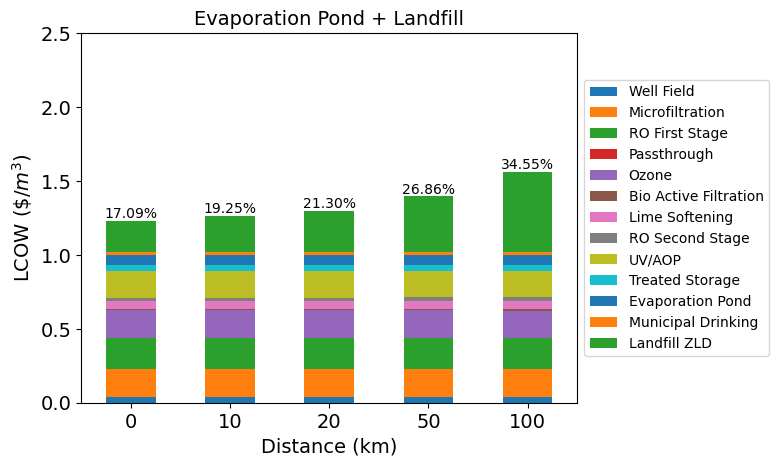

In [ ]:
scenarios = ['zld_a_0','zld_a_10', 'zld_a_20','zld_a_50','zld_a_100']

df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_zld_a_10.csv')
units = df['Unit Process Name'].unique() 

data = pd.DataFrame( columns = units[1::])

for scenario in scenarios:
    df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_' + scenario + '.csv')
    new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
    temp = pd.DataFrame(new_row , columns = units[1::],index= [scenario] )

    data = pd.concat([data,temp])

data.reset_index(inplace=True)
data = data.rename(columns={'index':'scenario'})
print(data)
ax = data.plot.bar(x='scenario',stacked = True)
ax.set_ylim([0,2.5])
ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Distance (km)',fontsize =14)
ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize =14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# data.sum()
perc_tranport = data['Landfill ZLD']/data.sum(axis=1)*100
perc_tranport = ["{:.2f}".format(x)+"%" for x in perc_tranport ]
ax.bar_label(ax.containers[-1],labels=perc_tranport,label_type ='edge',fontsize=10)
ax.set_title('Evaporation Pond + Landfill',fontsize=14)



Sensitivity check on crystallizer and zld case with transport distance being varied:
1. This is the maximum cost case for the AMO project- verify this?
2. Need to add transportation cost for solid transport?

In [ ]:
case_study = 'big_spring'
# scenario = 'baseline'
scenarios = ['zld_c_0','zld_c_10', 'zld_c_20','zld_c_50','zld_c_100']
desired_recovery = 1
ro_bounds = 'other' # or 'seawater'

LCOWList = np.array([])

for scenario in scenarios:
    m = watertap_setup(case_study=case_study, scenario=scenario, treatment_file_path = 'data/treatment_train_big_spring_zld_c_sensitivity.csv')
    m = get_case_study(m=m)
    m = run_watertap3(m, desired_recovery=desired_recovery, ro_bounds=ro_bounds, treatment_file_path = 'data/treatment_train_big_spring_zld_c_sensitivity.csv')
    m.fs.ro_first_stage.membrane_area.unfix()
    m.fs.ro_first_stage.feed.pressure.unfix()
    m.fs.ro_second_stage.membrane_area.unfix()
    m.fs.ro_second_stage.feed.pressure.unfix()
    m = run_and_return_model(m, objective=True)    
    LCOWList= np.concatenate((LCOWList,[scenario,m.fs.costing.LCOW.value()]))

LCOWList


Case Study = BIG SPRING
Scenario = ZLD C 0


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
RO FIRST STAGE
PASSTHROUGH
OZONE
BIO ACTIVE FILTRATION
LIME SOFTENING
RO SECOND STAGE
UV AOP
TREATED STORAGE
BRINE CONCENTRATOR
CRYSTALLIZER
MUNICIPAL DRINKING
LANDFILL ZLD


=========================START WT3 MODEL RUN==========================
.................................

Degrees of Freedom: 4

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................
.................................

Degrees of Freedom: 4

Initial solve attempt OPTIMAL

WaterTAP3 solution OPTIMAL

.................................

Case Study = BIG SPRING
Scenario = ZLD C 0


=========================ADDING UNIT PROCESSES=========================
WELL FIELD
MICROFILTRATION
RO FIRST STAGE
PASSTHROUGH
OZONE
BIO ACTIVE FILTRATION
LIME SOFTENING
RO SECOND STAGE
UV AOP
TREATED STORAGE
BRINE CONCENTRATOR
CRYSTALLIZER
MUNICIPAL DRINKING
LA

array(['zld_c_0', '1.7604882137922544', 'zld_c_10', '1.7918606640369377',
       'zld_c_20', '1.8235498307118392', 'zld_c_50', '1.9186162661006485',
       'zld_c_100', '2.077056792662113'], dtype='<U32')

Text(0.5, 1.0, 'Brine Concentrator + Crystallizer + Landfill')

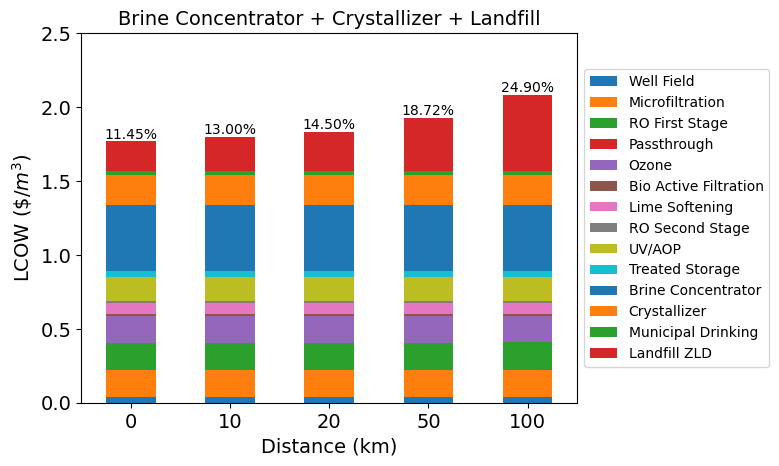

In [ ]:
scenarios = ['zld_c_0','zld_c_10', 'zld_c_20','zld_c_50','zld_c_100']
df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_zld_c_10.csv')
units = df['Unit Process Name'].unique() 

data = pd.DataFrame( columns = units[1::])

for scenario in scenarios:
    df = pd.read_csv('/Users/mhardika/Documents/watertap3/WaterTAP3/watertap3/watertap3/results/case_studies/big_spring_' + scenario + '.csv')
    new_row = [df[(df['Variable'] == 'Unit LCOW') ]['Value'].values]
    temp = pd.DataFrame(new_row , columns = units[1::],index= [scenario] )

    data = pd.concat([data,temp])

data.reset_index(inplace=True)
data = data.rename(columns={'index':'scenario'})
# print(data)

# print(data.sum(axis=1))
# print(data['Landfill ZLD']/data.sum(axis=1)*100)


ax = data.plot.bar(x='scenario',stacked = True)
ax.set_ylim([0,2.5])
ax.set_xticklabels([0,10,20,50,100], rotation = 0,fontsize =14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Distance (km)',fontsize =14)
ax.set_ylabel('LCOW (\$/${m^3}$)',fontsize =14)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

perc_tranport = data['Landfill ZLD']/data.sum(axis=1)*100

perc_tranport = ["{:.2f}".format(x)+"%" for x in perc_tranport ]
ax.bar_label(ax.containers[-1],labels=perc_tranport,label_type ='edge',fontsize =10)
ax.set_title('Brine Concentrator + Crystallizer + Landfill',fontsize =14)
# data.sum()

    